In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
from ptflops import get_model_complexity_info
from skimage.transform import resize
import os
import torch
import glob
import random
import torch.nn as nn
import torch.optim as op
import torch.nn.functional as F
import datetime

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

In [ ]:
#Needed for model complexity function
!pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=25bbaa8184381e065a84ba6f4bf9ce59d7a07fd52117d4a2b49edb7e96eccff5
  Stored in directory: /root/.cache/pip/wheels/c8/71/2f/92426c1ef33fb2e275b533878d8378f91c7f26846d9669019c
Successfully built ptflops


In [ ]:
#Make new directory for Kaggle json file
!mkdir ~/.kaggle

In [ ]:
#Copy .json file to new directory
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download training dataset
!kaggle datasets download grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:05<00:00, 249MB/s]
100% 1.03G/1.03G [00:05<00:00, 201MB/s]


In [ ]:
#Download test dataset
!kaggle datasets download danrasband/asl-alphabet-test

 37% 9.00M/24.3M [00:00<00:01, 14.7MB/s]
100% 24.3M/24.3M [00:00<00:00, 39.9MB/s]


In [ ]:
#Unzip training dataset
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
#Unzip test dataset
!unzip asl-alphabet-test.zip

Archive:  asl-alphabet-test.zip
  inflating: A/A0001_test.jpg        
  inflating: A/A0002_test.jpg        
  inflating: A/A0003_test.jpg        
  inflating: A/A0004_test.jpg        
  inflating: A/A0005_test.jpg        
  inflating: A/A0006_test.jpg        
  inflating: A/A0007_test.jpg        
  inflating: A/A0008_test.jpg        
  inflating: A/A0009_test.jpg        
  inflating: A/A0010_test.jpg        
  inflating: A/A0011_test.jpg        
  inflating: A/A0012_test.jpg        
  inflating: A/A0013_test.jpg        
  inflating: A/A0014_test.jpg        
  inflating: A/A0015_test.jpg        
  inflating: A/A0016_test.jpg        
  inflating: A/A0017_test.jpg        
  inflating: A/A0018_test.jpg        
  inflating: A/A0019_test.jpg        
  inflating: A/A0020_test.jpg        
  inflating: A/A0021_test.jpg        
  inflating: A/A0022_test.jpg        
  inflating: A/A0023_test.jpg        
  inflating: A/A0024_test.jpg        
  inflating: A/A0025_test.jpg        
  inflating: A/A00

In [ ]:
#Set training directory
data_path = '/content/asl_alphabet_train/asl_alphabet_train'
data_path_test = '/content/asl-alphabet-test'

#Set up transform pipelines
train_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor()])
#transforms.Normalize(mean=[0.485, 0.456, 0.406],
#std=[0.229, 0.224, 0.225])])


test_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])])

augment_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.CenterCrop(55),
transforms.RandomHorizontalFlip(.50),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])
 
data = datasets.ImageFolder(data_path, transform=train_transforms)
test = datasets.ImageFolder(data_path_test, transform=train_transforms)
num_samples = len(data)
num_samples

87000

In [ ]:
test_size = 0.2
batch_size = 128
num_epoch = 10
learning_rate = 0.001
num_classes = 29

In [ ]:
#Split dataset into training and validation
torch.manual_seed(1)
indices = torch.randperm(num_samples)

split = int(num_samples * test_size)

train_dataset = torch.utils.data.Subset(data, indices[split:])
val_dataset = torch.utils.data.Subset(data, indices[:split])

len(train_dataset), len(val_dataset)

(69600, 17400)

In [ ]:
#Create train/val/test dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test,
                                              batch_size=batch_size,
                                              shuffle=False)

classes = train_dataloader.dataset.dataset.classes

Ground truth Y


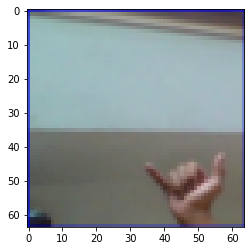

In [ ]:
for img, label in train_dataloader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

In [ ]:
#Define ResNet blocks
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [ ]:
#Default ResNet class
class ResNet_10(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
    self.fc1 = nn.Linear(16*16*n_chans1, 32)
    self.fc2 = nn.Linear(32, 29)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 16*16*self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
#ResNet class with 10 resblocks, p = 0.3 dropout layers
class ResNet_Dropout(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_dropout = nn.Dropout2d(p=0.3)
    self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
    self.conv2_dropout = nn.Dropout2d(p=0.3)
    self.fc1 = nn.Linear(16*16*n_chans1, 32)
    self.fc2 = nn.Linear(32, 29)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.conv1_dropout(out)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = self.conv2_dropout(out)
    out = out.view(-1, 16*16*self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
#ResNet class with  10 resblocks, Batch Normalization layers
class ResNet_Batch(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.fc1 = nn.Linear(16 * 16 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 29)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.resblocks(out)
        out = self.conv2_batchnorm(out)
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 16 * 16 * self.n_chans1)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#Choose GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [ ]:
#Create training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
#Training loop for weight decay with lambda = 0.001
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_dataloader)))

In [ ]:
#Create validate loop
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

In [ ]:
#Create test loop
def test(loader, model):
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

In [ ]:
#Compile default ResNet_10 model
model_ResNet_Default = ResNet_10(n_chans1=32, n_blocks=10).to(device=device)
optimizer = op.SGD(model_ResNet_Default.parameters(), momentum=0.9, lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Obtain MACs/Model size for default ResNet_10 model
macs, params = get_model_complexity_info(model_ResNet_Default, (3, 64, 64), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       98.96 MMac
Number of parameters:           273.31 k


In [ ]:
#Call training loop for default ResNet_10 model
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_ResNet_Default,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

2022-05-12 01:49:07.371474 Epoch 1, Training loss 3.3050358926548675
2022-05-12 02:04:47.845824 Epoch 2, Training loss 2.754778532859157
2022-05-12 02:20:02.181167 Epoch 3, Training loss 2.137430721126935
2022-05-12 02:35:22.461839 Epoch 4, Training loss 1.5780759604976458
2022-05-12 02:50:49.220318 Epoch 5, Training loss 0.9247679319232702
2022-05-12 03:05:58.266171 Epoch 6, Training loss 0.46252073317437487
2022-05-12 03:21:12.316801 Epoch 7, Training loss 0.30259381397627294
2022-05-12 03:36:25.387860 Epoch 8, Training loss 0.21896472243208656
2022-05-12 03:51:33.253749 Epoch 9, Training loss 0.15814214018310474
2022-05-12 04:06:41.336499 Epoch 10, Training loss 0.1173421885297798


In [ ]:
#Call validate loop for default ResNet_10 model
validate(model_ResNet_Default, train_dataloader, val_dataloader)

Accuracy train: 0.98
Accuracy val: 0.97


In [ ]:
#Call test loop for default ResNet_10 model
test(test_dataloader, model_ResNet_Default)

Got 75 / 870 with accuracy 8.62


In [ ]:
#Compile ResNet_10 model for weight decay training
model_ResNet_Weight_Decay = ResNet_10(n_chans1=32, n_blocks=10).to(device=device)
optimizer = op.SGD(model_ResNet_Weight_Decay.parameters(), momentum=0.9, lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Obtain MACs/Model size for ResNet_10 model with weight decay
macs, params = get_model_complexity_info(model_ResNet_Weight_Decay, (3, 64, 64), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
#Call training loop for ResNet_10 model with weight decay
training_loop_l2reg(
    n_epochs = num_epoch,
    optimizer = optimizer,
    model = model_ResNet_Weight_Decay,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

2022-05-11 18:55:48.338119 Epoch 1, Training loss 3.2830744784544494
2022-05-11 18:57:50.966672 Epoch 2, Training loss 3.1501277834177017
2022-05-11 18:59:53.811289 Epoch 3, Training loss 3.0926171896212242
2022-05-11 19:01:56.640775 Epoch 4, Training loss 3.046862689449507
2022-05-11 19:03:59.096766 Epoch 5, Training loss 3.0120007159078823
2022-05-11 19:06:02.048959 Epoch 6, Training loss 2.967764442019603
2022-05-11 19:08:04.947996 Epoch 7, Training loss 2.942262854646234
2022-05-11 19:10:07.686080 Epoch 8, Training loss 2.918553699465359
2022-05-11 19:12:10.202797 Epoch 9, Training loss 2.897091235308086
2022-05-11 19:14:12.958640 Epoch 10, Training loss 2.8810644964961445


In [ ]:
#Call validate loop for ResNet_10 model with weight decay
validate(model_ResNet_Weight_Decay, train_dataloader, val_dataloader)

Accuracy train: 0.11
Accuracy val: 0.11


In [ ]:
#Call test loop for ResNet_10 model with weight decay
test(test_dataloader, model_ResNet_Weight_Decay)

Got 42 / 870 with accuracy 4.83


In [ ]:
#Compile ResNet_10 model with p = 0.3 dropout layers
model_ResNet_Dropout = ResNet_Dropout(n_chans1=32, n_blocks=10).to(device=device)
optimizer = op.SGD(model_ResNet_Dropout.parameters(), momentum=0.9, lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Obtain MACs/Model size for ResNet_10 model with p = 0.3 dropout layers
macs, params = get_model_complexity_info(model_ResNet_Dropout, (3, 64, 64), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       98.96 MMac
Number of parameters:           273.31 k


In [ ]:
#Call training loop for ResNet_10 model with p = 0.3 dropout layers
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_ResNet_Dropout,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

2022-05-12 04:24:49.992038 Epoch 1, Training loss 3.175259857931558
2022-05-12 04:40:04.137179 Epoch 2, Training loss 2.2289191705777363
2022-05-12 04:55:31.856033 Epoch 3, Training loss 1.462685885893948
2022-05-12 05:10:56.424174 Epoch 4, Training loss 0.9350385744234219
2022-05-12 05:26:13.043918 Epoch 5, Training loss 0.557251087636413
2022-05-12 05:41:22.630376 Epoch 6, Training loss 0.3407556714818758
2022-05-12 05:56:38.344502 Epoch 7, Training loss 0.2317436614402515
2022-05-12 06:12:06.514920 Epoch 8, Training loss 0.15884906620554187
2022-05-12 06:27:44.767237 Epoch 9, Training loss 0.12062897214063388
2022-05-12 06:43:21.787993 Epoch 10, Training loss 0.10075181785642225


In [ ]:
#Call validate loop for ResNet_10 model with p = 0.3 dropout layers
validate(model_ResNet_Dropout, train_dataloader, val_dataloader)

Accuracy train: 0.97
Accuracy val: 0.96


In [ ]:
#Call test loop for ResNet_10 model with p = 0.3 dropout layers
test(test_dataloader, model_ResNet_Dropout)

Got 60 / 870 with accuracy 6.90


In [ ]:
#Compile ResNet_10 model with batch norm layers
model_ResNet_BatchNorm = ResNet_Batch(n_chans1=32, n_blocks=10).to(device=device)
optimizer = op.SGD(model_ResNet_BatchNorm.parameters(), momentum=0.9, lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Obtain MACs/Model size for ResNet_10 model with batch norm layers
macs, params = get_model_complexity_info(model_ResNet_BatchNorm, (3, 64, 64), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
#Call training loop for ResNet model with batch norm layers
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_ResNet_BatchNorm,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

2022-05-11 19:43:32.162715 Epoch 1, Training loss 2.628112838987042
2022-05-11 19:45:36.763885 Epoch 2, Training loss 1.8724868766525213
2022-05-11 19:47:41.450065 Epoch 3, Training loss 1.391117300838232
2022-05-11 19:49:45.853231 Epoch 4, Training loss 1.0544529115671621
2022-05-11 19:51:50.844275 Epoch 5, Training loss 0.8017841673949185
2022-05-11 19:53:55.706436 Epoch 6, Training loss 0.6167923052083043
2022-05-11 19:56:00.579684 Epoch 7, Training loss 0.48404303631361795
2022-05-11 19:58:05.293850 Epoch 8, Training loss 0.39320080108283195
2022-05-11 20:00:10.001520 Epoch 9, Training loss 0.3224804272108218
2022-05-11 20:02:15.029440 Epoch 10, Training loss 0.2686151022584561


In [ ]:
#Call validate loop for ResNet model with batch norm layers
validate(model_ResNet_BatchNorm, train_dataloader, val_dataloader)

Accuracy train: 0.98
Accuracy val: 0.98


In [ ]:
#Call test loop for ResNet model with batch norm layers
test(test_dataloader, model_ResNet_BatchNorm)

Got 49 / 870 with accuracy 5.63


In [ ]:
#Compile ResNet model with 20 resblocks
model_ResNet_20 = ResNet_10(n_chans1=32, n_blocks=20).to(device=device)
optimizer = op.SGD(model_ResNet_20.parameters(), momentum=0.9, lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Obtain MACs/Model size for ResNet_10 model with 20 resblocks
macs, params = get_model_complexity_info(model_ResNet_20, (3, 64, 64), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
#Call training loop for ResNet model with 20 resblocks
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_ResNet_20,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

2022-05-11 20:06:39.366030 Epoch 1, Training loss 3.3809938071405186
2022-05-11 20:08:54.894596 Epoch 2, Training loss 3.3707465963328587
2022-05-11 20:11:10.448427 Epoch 3, Training loss 3.3696551629725624
2022-05-11 20:13:25.878913 Epoch 4, Training loss 3.3689084508839775
2022-05-11 20:15:41.215352 Epoch 5, Training loss 3.368398099699441
2022-05-11 20:17:56.403026 Epoch 6, Training loss 3.368047807146521
2022-05-11 20:20:11.945648 Epoch 7, Training loss 3.3678023674908806
2022-05-11 20:22:27.691845 Epoch 8, Training loss 3.367643082404838
2022-05-11 20:24:43.227880 Epoch 9, Training loss 3.367529505315949
2022-05-11 20:26:58.405238 Epoch 10, Training loss 3.3674510388689884


In [ ]:
#Call validate loop for ResNet model with 20 resblocks
validate(model_ResNet_20, train_dataloader, val_dataloader)

Accuracy train: 0.03
Accuracy val: 0.03


In [ ]:
#Call test loop for ResNet model with 20 resblocks
test(test_dataloader, model_ResNet_20)

Got 30 / 870 with accuracy 3.45


In [ ]:
#torch.save(model.state_dict(), 'res10.pth')

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
 
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable


In [ ]:
from google.colab.patches import cv2_imshow
testImage = cv2.imread('/content/photo.jpg')

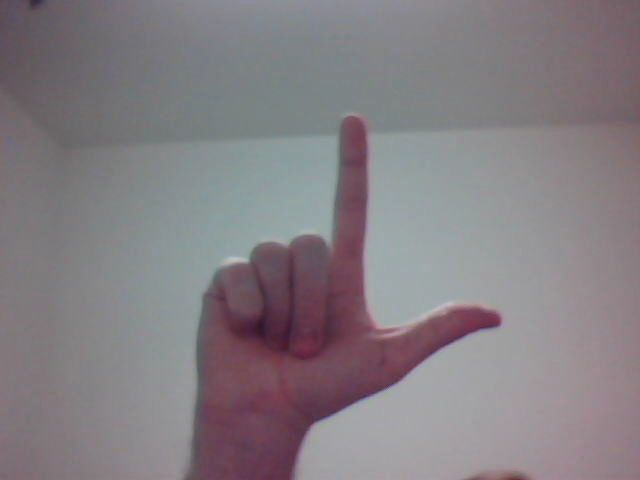

In [ ]:
cv2_imshow(testImage)

In [ ]:
from PIL import Image
from matplotlib import cm
from PIL import Image
import numpy as np
new_im = Image.fromarray(testImage)

preprocess = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])])

# Convert the image to PyTorch tensor
tensor = preprocess(new_im)

# print the converted image tensor
print(tensor)

tensor([[[-0.5938, -0.5253, -0.6452,  ..., -0.3369, -0.3712, -0.4054],
         [-0.5938, -0.5253, -0.5767,  ..., -0.3027, -0.3541, -0.3883],
         [-0.5938, -0.4911, -0.5082,  ..., -0.3027, -0.3369, -0.3712],
         ...,
         [-0.0972, -0.0972, -0.0972,  ...,  0.1768,  0.1254,  0.0912],
         [-0.1143, -0.1143, -0.0972,  ...,  0.2111,  0.1426,  0.0912],
         [-0.1657, -0.1657, -0.1486,  ...,  0.1426,  0.1083,  0.0569]],

        [[-0.6702, -0.6527, -0.7227,  ..., -0.3200, -0.3725, -0.3901],
         [-0.6352, -0.6176, -0.6176,  ..., -0.3025, -0.3550, -0.3725],
         [-0.6527, -0.6001, -0.5651,  ..., -0.3025, -0.3200, -0.3375],
         ...,
         [-0.0924, -0.0924, -0.0924,  ...,  0.1877,  0.1527,  0.0826],
         [-0.1099, -0.1275, -0.1099,  ...,  0.1877,  0.1527,  0.1001],
         [-0.1625, -0.1625, -0.1450,  ...,  0.1527,  0.1001,  0.0476]],

        [[-0.2010, -0.2010, -0.2358,  ...,  0.1999,  0.1825,  0.1651],
         [-0.2010, -0.1835, -0.1487,  ...,  0

In [ ]:
#create batch from test image
batch_t = torch.unsqueeze(tensor, 0)
batchDevice = batch_t.to(device)

In [ ]:
#Generate outputs for each model
out1 = model_ResNet_Default(batchDevice)
out3 = model_ResNet_BatchNorm(batchDevice)
out4 = model_ResNet_Dropout(batchDevice)

In [ ]:
out1

tensor([[ 4.0246,  1.8327,  3.0079,  3.6211,  3.8010,  2.6260, -0.3461, -0.1029,
          0.7174, -3.3826, -1.2429, -0.2047,  1.7924,  2.3290,  1.2263, -2.0605,
         -1.1362,  0.2395, -0.0178, -0.7636, -1.7873, -3.8731, -3.4343, -0.9221,
         -1.3866, -1.1327, -0.8652, -0.1838, -0.9535]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
#loading the 1000 labels, which are uploaded to the drive in this case
with open('/content/signLanguage_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

In [ ]:
#Determine top 5 highest scoring classes from Default ResNet_10 model
_, indices = torch.sort(out1, descending=True)
percentage = torch.nn.functional.softmax(out1, dim=1)[0] * 100
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[("2: 'C',", 93.12557983398438),
 ("11: 'L',", 3.572153329849243),
 ("16: 'Q',", 3.293961763381958),
 ("19: 'T',", 0.005521539598703384),
 ("14: 'O',", 0.0027548717334866524)]

In [ ]:
#Determine top 5 highest scoring classes from ResNet_10 model with batch norm
_, indices = torch.sort(out3, descending=True)
percentage = torch.nn.functional.softmax(out3, dim=1)[0] * 100
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

In [ ]:
#Determine top 5 highest scoring classes from ResNet_10 model with dropout 
_, indices = torch.sort(out4, descending=True)
percentage = torch.nn.functional.softmax(out4, dim=1)[0] * 100
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[("2: 'C',", 95.8673095703125),
 ("25: 'Z',", 3.915085554122925),
 ("11: 'L',", 0.21716535091400146),
 ("3: 'D',", 0.00032646252657286823),
 ("19: 'T',", 7.668300531804562e-05)]